# Drawing Guesser 
## Pedro Luiz & Gabriel Zezze

### O dataset
O drawing guesser se baseia no [dataset de desenhos dispopnibilizados pelo Google](https://github.com/googlecreativelab/quickdraw-dataset) gerado através do jogo [QuickDraw](https://quickdraw.withgoogle.com/).

O dataset completo consiste de 150 mil desenhos que são imagens bitmap de 28x28 para cada categoria sendo que há 345 categorias disponibilizadas.

O intuito do drawing guesser é simular o proprio QuickDraw, ou seja, fazer classificações do desenho enquanto o jogador desenha, porém com um número limitado de catogrias (x) e uma rede neural própria treinada a partir do dataset disponibilizado.

### O problema

Este é um problema de classifição multiclasse dos desenhos dispoinibilizados no dataset. Para realizar essa classificação vamos utilizar uma rede convulacional que será explicada detalhadamente abaixo.


In [3]:
#IMPORTS
import pandas as pd
import numpy as np
import ujson as json
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization
import tensorflow as tf
from sklearn.metrics import classification_report

In [4]:
#DECLARE CONSTANTS
IMG_HEIGHT = 28
IMG_WIDTH = 28
NUM_FILES = 35000
N_EPOCHS = 300
RANDOM_SEED = 42

### Extração de dados

O dataset utilizado disponibiliza arquivos do tipo numpy bit array, que quando lidos com a função `numpy.load` retorna um numpy array. Contudo, esse array possui apenas uma dimensão. Dessa forma, é necessário fazer o reshape de cada imagem lida para se tornar uma matriz 28x28. 

In [5]:
#GETTING ALL FILE NAMES
data_files = os.listdir('./data/')
data_files = [f'./data/{file}' for file in data_files]
if data_files.count('./data/.DS_Store') > 0:
    data_files.remove('./data/.DS_Store')
N_CATEGORIES = len(data_files)

print(data_files)
print(N_CATEGORIES)

['./data/book.npy', './data/bus.npy', './data/camel.npy', './data/apple.npy', './data/airplane.npy', './data/cactus.npy', './data/bush.npy', './data/butterfly.npy', './data/calculator.npy', './data/bird.npy', './data/ambulance.npy', './data/cake.npy', './data/beach.npy', './data/axe.npy', './data/banana.npy', './data/calendar.npy', './data/alarm clock.npy', './data/basketball.npy', './data/bed.npy', './data/barn.npy']
20


In [6]:
#READING FILES AND POPULATING TOTAL X AND Y
all_drawings = []
all_categories = []

for idx, file in enumerate(data_files):
    data = np.load(file)[:NUM_FILES]
    for d in data:
        reshaped_img = np.array(np.reshape(d, (-1, 28))).astype(np.float32)
        
        all_drawings.append(reshaped_img)
        all_categories.append(idx)

all_drawings = np.array(all_drawings)
all_categories = np.array(all_categories)

### Selecao de dados entre dados de treinamento e teste

Antes de qualquer treinamento ou teste em cima dos dados é necessário separá-los em dados de treinamento e teste sendo 20% dos dados seprados para teste e o restante para treinamento. 

Após essa separação os dados de trinamento serão divididos mais uma vez, sendo que 80% deste dados serao para treinamento do modelo e 20% para validação do treinamento.


In [7]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(all_drawings, all_categories, test_size=0.2, random_state=RANDOM_SEED)

## Estabelecendo uma base
Antes de iniciar a criação da rede convolucional, precisamos de uma base para saber se nosso modelo faz classificaçõeses melhores que modelos aleatórios. Para isso vamos utilizar o classificador Random Forrest para estabelecer um mínimo de performance para nosso modelo convolucional. Dessa forma, se a rede concolucional criada possuir desempenho similar ao classificador aleatório, não podemos dizer que obtivemos qualquer sucesso.

Como o classificador Random forrest recebe dados de treinamento de uma forma diferente (Vetores de no máximo duas dimensões) que uma rede convolucional, precisamos mudar o formato das features para treiná-lo.
Após treinar o classificador Random forest usamos o método `cross_val_score` para separarmos os dados de treinamento em 5 divisoes. Esse método combina 4 divisões para treinamento e a divisão restante para validação. Por fim, obtivemos os seguintes valores de acurácia de validação:

1. x
1. y
1. h

In [8]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# random_forest_X_train = np.array([x.flatten() for x in X_train_full])
# random_forrest_clf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)

# cross_val_score(random_forrest_clf, random_forest_X_train, y_train_full, cv=5, n_jobs=-1)

### Montagem da rede convolucional

O modelo criado possui 3 conjuntos de camadas convolucionais seguidas de um max pooling. Os filtros da camada convolucional começam em 8 e vão dobrando, já para o kernel initializer foi utilizado o padrão que é o `glorot_uniform` de tamanho 3x3. Essas primeiras camadas tem o objetivo de destacar as features únicas(detalhes) de cada categoria. Em seguida é realizado o Flatten para transformar todas as camadas em uma array 1D e um Batch Normalization para padronizar os valores, ou seja, centralizar sua média em 0 e o desvio padrão em 1. Também foi adicionada uma camada de Dropout para evitar o overfitting. Na sequência, os inputs normalizados  são passados para uma camada Densa, a qual recebe dois parametros, número de neurônios e função de ativação que sera usada, assim a camada densa recebe as features, multiplica pelos respectivos pesos e soma esta multiplicação para finalmente passar pela funcao de ativação. Em seguida é aplicada mais uma batch normalization e um dropout. Por fim, é aplicada mais uma camada Dense com units = número de categorias, com a função de ativação soft max, para obter o resultado da classificação.

#### Entradas e saídas das camadas
```
(28, 28, 1) -> Primeira camada Conv2D -> (28, 28, 8)
(28, 28, 8) -> Primerira camada Maxpooling2D -> (14, 14, 8)
(14, 14, 8) -> Segunda camada Conv2D -> (14, 14, 16)
(14, 14, 16) -> Segunda camada Maxpooling2D -> (7, 7, 16)
(7, 7, 16) -> Terceira camada Conv2D -> (7, 7, 32)
(7, 7, 32) -> Terceira camada Maxpooling2D -> (4, 4, 32)
(4, 4, 32) -> Flatten -> (512)
(512) -> Dense -> (30)
(30) -> Dense -> (N)
```

In [9]:
slice_index = int(len(X_train_full)*0.8)

X_train = X_train_full[:slice_index][..., np.newaxis]
X_valid = X_train_full[slice_index:][..., np.newaxis]

y_train = y_train_full[:slice_index][..., np.newaxis]
y_valid = y_train_full[slice_index:][..., np.newaxis]

X_test = X_test[..., np.newaxis]

In [10]:
model = keras.models.Sequential([
    Conv2D(filters=8, kernel_size=3,padding="same", activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,1)),
    MaxPool2D(pool_size=2),

    Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
    MaxPool2D(pool_size=2),

    Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    MaxPool2D(pool_size=2),
    
    Flatten(),
    
    BatchNormalization(),
    Dropout(0.5, seed=RANDOM_SEED),
    Dense(units=30,activation="relu"),
    
    BatchNormalization(),
    Dropout(0.5, seed=RANDOM_SEED),
    Dense(units=N_CATEGORIES, activation="softmax"),
])

In [11]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [12]:
history = model.fit(X_train,y_train,epochs = N_EPOCHS, validation_data=(X_valid, y_valid), batch_size=264)

Epoch 1/325
1697/1697 [==============================] - 11s 4ms/step - loss: 2.6368 - accuracy: 0.2381 - val_loss: 1.7026 - val_accuracy: 0.5547
Epoch 2/325
1697/1697 [==============================] - 6s 4ms/step - loss: 1.8852 - accuracy: 0.4335 - val_loss: 1.3118 - val_accuracy: 0.6589
Epoch 3/325
1697/1697 [==============================] - 6s 3ms/step - loss: 1.5934 - accuracy: 0.5259 - val_loss: 1.0847 - val_accuracy: 0.7127
Epoch 4/325
1697/1697 [==============================] - 6s 4ms/step - loss: 1.4212 - accuracy: 0.5780 - val_loss: 0.9531 - val_accuracy: 0.7456
Epoch 5/325
1697/1697 [==============================] - 6s 4ms/step - loss: 1.3064 - accuracy: 0.6135 - val_loss: 0.8616 - val_accuracy: 0.7656
Epoch 6/325
1697/1697 [==============================] - 6s 4ms/step - loss: 1.2312 - accuracy: 0.6371 - val_loss: 0.7977 - val_accuracy: 0.7819
Epoch 7/325
1697/1697 [==============================] - 6s 4ms/step - loss: 1.1725 - accuracy: 0.6569 - val_loss: 0.7519 - val_a

1697/1697 [==============================] - 6s 3ms/step - loss: 0.7273 - accuracy: 0.7966 - val_loss: 0.4400 - val_accuracy: 0.8775
Epoch 114/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.7277 - accuracy: 0.7973 - val_loss: 0.4435 - val_accuracy: 0.8772
Epoch 115/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7276 - accuracy: 0.7968 - val_loss: 0.4391 - val_accuracy: 0.8780
Epoch 116/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7262 - accuracy: 0.7974 - val_loss: 0.4397 - val_accuracy: 0.8775
Epoch 117/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7266 - accuracy: 0.7972 - val_loss: 0.4381 - val_accuracy: 0.8785
Epoch 118/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7261 - accuracy: 0.7977 - val_loss: 0.4385 - val_accuracy: 0.8778
Epoch 119/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7275 - accuracy: 0.7968 - val_loss: 0.4390 - val_ac

Epoch 169/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7048 - accuracy: 0.8033 - val_loss: 0.4289 - val_accuracy: 0.8803
Epoch 170/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7053 - accuracy: 0.8029 - val_loss: 0.4281 - val_accuracy: 0.8803
Epoch 171/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7045 - accuracy: 0.8036 - val_loss: 0.4312 - val_accuracy: 0.8800
Epoch 172/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7073 - accuracy: 0.8035 - val_loss: 0.4288 - val_accuracy: 0.8809
Epoch 173/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7067 - accuracy: 0.8031 - val_loss: 0.4302 - val_accuracy: 0.8797
Epoch 174/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.7037 - accuracy: 0.8037 - val_loss: 0.4279 - val_accuracy: 0.8808
Epoch 175/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.7030 - accuracy: 0.8039 - val_loss: 0

Epoch 225/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6971 - accuracy: 0.8057 - val_loss: 0.4234 - val_accuracy: 0.8823
Epoch 226/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6955 - accuracy: 0.8063 - val_loss: 0.4264 - val_accuracy: 0.8813
Epoch 227/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6934 - accuracy: 0.8068 - val_loss: 0.4223 - val_accuracy: 0.8823
Epoch 228/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6958 - accuracy: 0.8060 - val_loss: 0.4228 - val_accuracy: 0.8821
Epoch 229/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6957 - accuracy: 0.8061 - val_loss: 0.4229 - val_accuracy: 0.8823
Epoch 230/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6940 - accuracy: 0.8057 - val_loss: 0.4223 - val_accuracy: 0.8824
Epoch 231/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6947 - accuracy: 0.8058 - val_loss: 0

Epoch 281/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6912 - accuracy: 0.8075 - val_loss: 0.4211 - val_accuracy: 0.8822
Epoch 282/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6902 - accuracy: 0.8074 - val_loss: 0.4208 - val_accuracy: 0.8825
Epoch 283/325
1697/1697 [==============================] - 6s 4ms/step - loss: 0.6894 - accuracy: 0.8077 - val_loss: 0.4195 - val_accuracy: 0.8830
Epoch 284/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6909 - accuracy: 0.8073 - val_loss: 0.4193 - val_accuracy: 0.8829
Epoch 285/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6893 - accuracy: 0.8080 - val_loss: 0.4199 - val_accuracy: 0.8823
Epoch 286/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6886 - accuracy: 0.8078 - val_loss: 0.4212 - val_accuracy: 0.8820
Epoch 287/325
1697/1697 [==============================] - 6s 3ms/step - loss: 0.6899 - accuracy: 0.8079 - val_loss: 0

In [16]:
model.save('./trained_models/')

INFO:tensorflow:Assets written to: ./trained_models/assets


INFO:tensorflow:Assets written to: ./trained_models/assets


### Análise do treinamento
Pode-se perceber pelos gráficos 1 e 2 que o modelo apresenta uma melhora na acurácia e no erro a cada iteração. Além disso, a validação acompanha essa melhora do treinamento, ou seja, o modelo apresenta bons resultados para o que ele está sendo treinado e também para dados genéricos(dados que nao estavam presente no treinamento), eliminando a possibilidade de overfitting. Por fim, a acurácia de validação do treinamento e o erro dessa validação são melhores que o próprio treinamento, visto que há duas camadas de dropout durante o treinamento, que eliminam aleatóriamente alguns dados de entrada, mas mantendo a soma total das entradas. Dessa forma, o modelo não se acomoda com os dados de treinamento e é obrigado a ser capaz de generalizar (evitando overfitting).

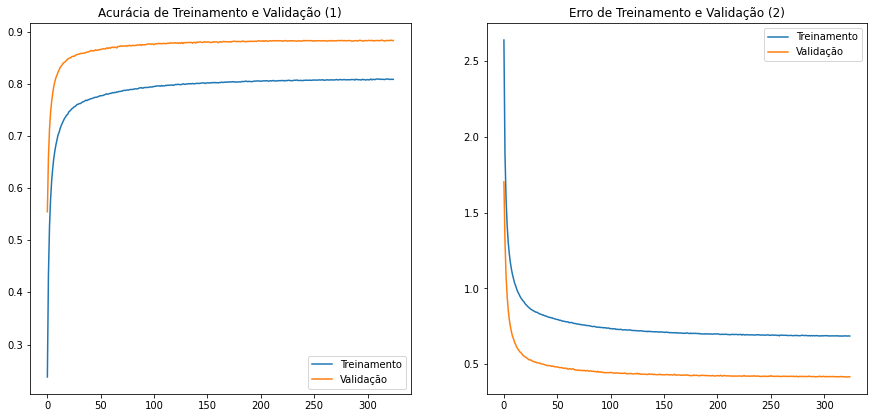

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(N_EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treinamento e Validação (1)')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treinamento e Validação (2)')
plt.show()

In [14]:
# score = model.evaluate(X_test, y_test)
# y_pred = model.predict(X_test)

In [15]:
predictions = model.predict_classes(X_test)

categories = [x.split('/')[-1].split('.')[0] for x in data_files]
print(classification_report(y_test, predictions, target_names = categories)) 

/home/gabrielzezze/.local/share/virtualenvs/ProjetoML-I6gg8voT/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        book       0.89      0.89      0.89      6967
         bus       0.85      0.89      0.87      6933
       camel       0.92      0.93      0.92      7029
       apple       0.95      0.95      0.95      6992
    airplane       0.87      0.88      0.88      7039
      cactus       0.90      0.89      0.90      6956
        bush       0.84      0.84      0.84      7079
   butterfly       0.93      0.94      0.94      7041
  calculator       0.88      0.90      0.89      6910
        bird       0.79      0.76      0.78      6972
   ambulance       0.88      0.83      0.85      7023
        cake       0.91      0.90      0.91      6981
       beach       0.82      0.90      0.86      6942
         axe       0.88      0.93      0.90      6978
      banana       0.93      0.94      0.93      7174
    calendar       0.81      0.81      0.81      6915
 alarm clock       0.91      0.84      0.88      7068
  basketball       0.91    

In [10]:
import cairocffi as cairo
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

(28, 28)


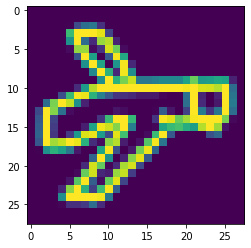

In [20]:
a = vector_to_raster([[[[167,109,80,69,58,31,57,117,99,52,30,6,1,2,66,98,253,254,246,182,165],[140,194,227,232,229,229,206,124,123,149,157,159,153,110,82,77,74,109,121,127,120]],[[207,207,210,221,238],[74,103,114,128,135]],[[119,107,76,70,49,39,60,93],[72,41,3,0,1,5,38,70]]]])
a = np.array(np.reshape(a, (-1, 28))).astype(np.float32)
print(a.shape)
plt.imshow(a)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e835f976-84f1-4f23-95fa-ef4e96b3c72d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>